In [ ]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import uuid


In [ ]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1): # 指定输入通道，输出通道
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
class ResNet_model(nn.Module):
    def __init__(self, num_classes = 2):
        super(ResNet_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1) # 输入为3个通道
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace = True)
        self.layer1 = self._make_layer(8, 16, 2, stride=2) # 输入通道、输出通道、块数
        self.layer2 = self._make_layer(16, 32, 2, stride=2)
        self.layer3 = self._make_layer(32, 32, 2, stride=2)
        self.layer4 = self._make_layer(32, 64, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 8)
        self.fc2 = nn.Linear(8, 2)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) # 4层layer，每个layer有两个残差块
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        return x
model = torch.load("ResNet.pth")

In [ ]:
def vis_cam(cam: np.ndarray, input_tensor: torch.Tensor):
    def normalization(x: np.ndarray, scale=1):   # 归一化
        x_min = np.min(x)
        x_max = np.max(x)
        return (x - x_min) / (x_max - x_min) * scale 
    
    # 底层是cv2实现的所以要求图像形状为 H x W x C
    input_tensor= input_tensor.permute(1, 2, 0).numpy()
    norm_img = normalization(input_tensor)
    
    # 可视化不支持batch，所以要取cam第一个
    vis = show_cam_on_image(norm_img, cam[0], use_rgb=True)
    
    vis_img = Image.fromarray(vis)
    # vis_img.save(f'cam_{uuid.uuid1()}.jpg')
    return vis_img

In [ ]:
def generate_grad_cam(model, img_root):
    img = cv2.imread(img_root)
    img_tensor = torch.from_numpy(img)
    # 重排维度从 (32, 16, 3) 到 (3, 32, 16)
    img_tensor = img_tensor.permute(2, 0, 1)
    grad_cam = GradCAM(model=model, target_layers=[model.layer1[-1]])   
    cam = grad_cam(input_tensor=img_tensor.unsqueeze(0).float()) # 输入的Shape: B x C x H x W
 
    # print(f'Cam.shape: {cam.shape}')
    # print(f'Cam.max: {cam.max()}, Cam.min: {cam.min()}')
    vis1 = vis_cam(cam, img_tensor)
    return vis1

In [ ]:
model.eval()

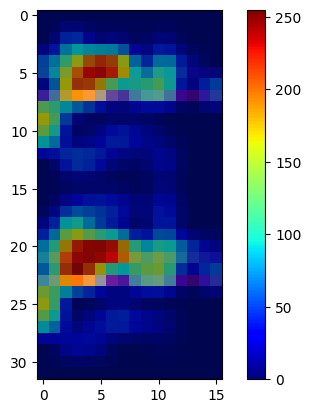

In [136]:
img_root = "./图像数据/1_failure/img_2509.png"
img = cv2.imread(img_root)
vis = generate_grad_cam(model, img_root)
plt.imshow(vis,cmap="jet")
plt.colorbar()

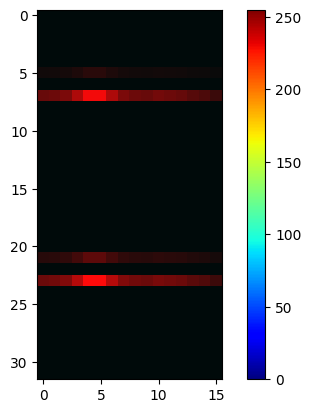

In [137]:
plt.imshow(img,"jet")
plt.colorbar()

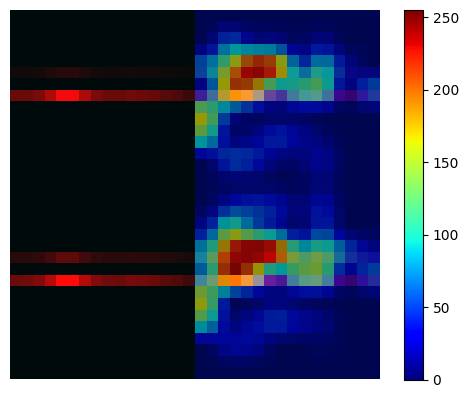

In [138]:
img_hstack = np.hstack([img, vis])
plt.imshow(img_hstack,"jet")
plt.axis("off")
plt.colorbar()

In [96]:
## 原矩阵
data = np.load("../failure_prediction3d/data_processed/data_mce3d.npy")
label = np.load("../failure_prediction3d/data_processed/labels.npy")

In [ ]:
label[10237]

In [ ]:
plt.imshow(vis,cmap="jet")
plt.colorbar()
plt.savefig(f"{img_root[-13:]}.png")